In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 22 05:33:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     On   | 00000000:1A:00.0 Off |                  Off |
| 33%   58C    P2   255W / 260W |  11262MiB / 48598MiB |     96%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     On   | 00000000:1B:00.0 Off |                  Off |
| 33%   

In [2]:
%matplotlib inline
import argparse
import json
import os

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from expert import Expert
from expert import AffineExpert
from expert import TranslationExpert
from expert import ConvolutionExpert
from discriminator import Discriminator
from discriminator import ConvolutionDiscriminator
from data import translated_gaussian_dataset
from data import single_translated_gaussian_dataset
from data import transformed_mnist_dataset
from data_utils import generated_transformed_mnist
from train_utils import initialize_experts
from train_utils import train_icm
from train_utils import train_gan

# New Section

In [3]:
# generated_transformed_mnist('./', 2, add_rotation=False)
# os.listdir('./')
# source_data = np.load("mnist_transformed_data_2_transform.npy", allow_pickle=True)

In [4]:
args = argparse.Namespace()
args.batch_size = 64
args.num_initialize_epoch = 30
args.min_initialization_loss = 0.1
args.num_epoch = 100
args.discriminator_output_size = 1
# args.input_shape = 2
# args.input_shape = [28, 28, 1]
args.input_shape = [32, 32, 3]
args.use_sn = True
args.num_experts = 10
args.discriminator_sigmoid = False
args.noise_scale = 0.1
args.print_iterval = 200
args.no_source_target = False
args.num_transform = 2
args.width_multiplier = 4

args.save_expert = False
args.use_saved_expert = False

args.cuda = torch.cuda.is_available()
args.device = torch.device("cuda:4" if args.cuda else "cpu")
print(args.cuda)
print(args.device)

True
cuda:4


In [5]:
def transformed_mnist_dataset(batch_size, args):
    num_transform = args.num_transform

    original_data_name = "mnist_original_data"
    transformed_data_name = "mnist_transformed_data"
    if num_transform > 1:
        original_data_name += "_{}_transform.npy".format(num_transform)
        transformed_data_name += "_{}_transform.npy".format(num_transform)

    source_data = np.load(original_data_name, allow_pickle=True)
    target_data = np.load(transformed_data_name, allow_pickle=True)

    source_data = np.transpose(source_data, [0, 3, 1, 2])
    target_data = np.transpose(target_data, [0, 3, 1, 2])

    np.random.shuffle(source_data)
    np.random.shuffle(target_data)

    target_size = target_data.shape[0]
    source_size = source_data.shape[0]
#     multiple = target_size // (source_size * 2)
#     source_data = np.concatenate([source_data] * multiple, axis=0)
#     target_data = target_data[: source_size * multiple]

    tensor_src = torch.Tensor(source_data)
    tensor_tgt = torch.Tensor(target_data)
    print(tensor_src.size(), tensor_tgt.size())

    dataset = torch.utils.data.TensorDataset(tensor_src, tensor_tgt)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=int(args.cuda),
        pin_memory=args.cuda,
        drop_last=True,
    )
    return dataloader


# class MNISTPair(torchvision.datasets.MNIST):

#     def __getitem__(self, index):
#         img, target = self.data[index], self.targets[index]
#         return img

def original_mnist_dataset(batch_size, args):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            root="./datasets",
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor()]
            ),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    data, label = [], []
    for x, y in train_loader:
        data.append(x.numpy())
        label.append(y.numpy())
    data = np.concatenate(data, axis=0)
    label = np.concatenate(label, axis=0)

    tensor_data = torch.Tensor(data)
    dataset = torch.utils.data.TensorDataset(tensor_data, tensor_data)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=int(args.cuda),
        pin_memory=args.cuda,
        drop_last=True,
    )
    return dataloader


def original_cifar10_dataset(batch_size, args):
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(
            root="./datasets",
            train=True,
            download=True,
            transform=torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor()]
            ),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    data, label = [], []
    for x, y in train_loader:
        data.append(x.numpy())
        label.append(y.numpy())
    data = np.concatenate(data, axis=0)
    label = np.concatenate(label, axis=0)

    tensor_data = torch.Tensor(data)
    dataset = torch.utils.data.TensorDataset(tensor_data, tensor_data)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=int(args.cuda),
        pin_memory=args.cuda,
        drop_last=True,
    )
    return dataloader

dataset_fn = original_cifar10_dataset

In [6]:
# Data

# data = single_translated_gaussian_dataset(args.batch_size, args, args.noise_scale)
# data = translated_gaussian_dataset(args.batch_size, args, dist=2.0)
# data = transformed_mnist_dataset(args.batch_size, args)
data = dataset_fn(args.batch_size, args)

# Model
# experts = [AffineExpert(args).to(args.device) for i in range(args.num_experts)]
# discriminator = Discriminator(args).to(args.device)

experts = [ConvolutionExpert(args).to(args.device) for i in range(args.num_experts)]
discriminator = ConvolutionDiscriminator(args).to(args.device)

Files already downloaded and verified


In [7]:
if args.use_saved_expert and os.path.exists('./', 'saved_weights', 'expert', args.expert_name):
    load_expert_weights(experts, args)
else:
    initialize_experts(experts, data, args)
    if args.save_expert:
        save_expert_weights(experts, args)

======Initializing experts to identity on target data===

initialization: expert 0 epoch 1 loss 0.0652
------------below threshold----------
initialization: expert 1 epoch 1 loss 0.0608
------------below threshold----------
initialization: expert 2 epoch 1 loss 0.0692
------------below threshold----------
initialization: expert 3 epoch 1 loss 0.0620
------------below threshold----------
initialization: expert 4 epoch 1 loss 0.0703
------------below threshold----------


Traceback (most recent call last):
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


initialization: expert 5 epoch 1 loss 0.0656
------------below threshold----------
initialization: expert 6 epoch 1 loss 0.0626
------------below threshold----------
initialization: expert 7 epoch 1 loss 0.0676
------------below threshold----------
initialization: expert 8 epoch 1 loss 0.0611
------------below threshold----------


Traceback (most recent call last):
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/userhome/ydjiang/miniconda3/envs/simclr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


initialization: expert 9 epoch 1 loss 0.0690
------------below threshold----------

======Finished initializing experts===



In [8]:
discriminator_opt = torch.optim.Adam(discriminator.parameters())
expert_opt = []
for e in experts:
    expert_opt.append(torch.optim.Adam(e.parameters()))

for n in range(args.num_epoch):
    train_icm(experts, expert_opt, discriminator, discriminator_opt, data, args)
#     train_gan(experts, expert_opt, discriminator, discriminator_opt, data, args)

/userhome/ydjiang/icm/train_utils.py:122: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  selected_idx = winning_idx.eq(i).nonzero().squeeze(dim=-1)


Discriminator expert Loss: 0.6763
Discriminator discriminator Loss: 0.7106
Per expert winning num: [64, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Discriminator expert Loss: 0.0390
Discriminator discriminator Loss: 0.0627
Per expert winning num: [0, 0, 0, 0, 0, 0, 45, 0, 19, 0]

Discriminator expert Loss: 0.2924
Discriminator discriminator Loss: 0.1033
Per expert winning num: [0, 0, 0, 64, 0, 0, 0, 0, 0, 0]

Discriminator expert Loss: 0.3485
Discriminator discriminator Loss: 0.1414
Per expert winning num: [51, 0, 0, 0, 0, 0, 13, 0, 0, 0]

Discriminator expert Loss: 0.4968
Discriminator discriminator Loss: 0.0568
Per expert winning num: [5, 1, 0, 58, 0, 0, 0, 0, 0, 0]

Discriminator expert Loss: 0.2746
Discriminator discriminator Loss: 0.1031
Per expert winning num: [0, 0, 0, 64, 0, 0, 0, 0, 0, 0]

Discriminator expert Loss: 0.1399
Discriminator discriminator Loss: 0.2302
Per expert winning num: [2, 0, 0, 62, 0, 0, 0, 0, 0, 0]

Discriminator expert Loss: 0.2733
Discriminator discriminator Loss: 0.1482

KeyboardInterrupt: 

# Visualization

In [9]:
source_data_np = next(iter
                      (dataset_fn(500, args)))[0].numpy()
target_data_np = next(iter(dataset_fn(500, args)))[1].numpy()

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# plt.imshow(np.reshape(target_data_np[9], [28, 28]))

In [11]:
img_t = experts[-2](torch.Tensor(target_data_np[:32]).to(args.device)).detach()

In [12]:
img_np = img_t.cpu().numpy()

In [13]:
img_np.shape

(32, 3, 32, 32)

In [14]:
# shape = [28, 28]
shape = [3, 32, 32]
def run_activated_expert(data, experts, activation_count, num_col=5):
  index = [i for i in range(len(activation_count)) if activation_count[i] > 0]
  out = [None for i in range(len(index))]
  print(index)
  for i, exp_i in enumerate(index):
    img_t = experts[exp_i](torch.Tensor(data[:num_col]).to(args.device)).detach()
    img_np = img_t.cpu().numpy()
    out[i] = [np.reshape(im, shape).transpose([1, 2, 0]) for im in img_np]
  out = [[np.reshape(im, shape).transpose([1, 2, 0]) for im in data[:num_col]]] + out
  return out

In [15]:
from mpl_toolkits.axes_grid1 import ImageGrid
def plot_output_grid(output):
  num_expert, num_example = len(output), len(output[0])
  fig = plt.figure(figsize=(20., 20.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(num_expert, num_example),  # creates 2x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                  )
  flat = []
  for exp_result in output:
    flat += exp_result
  for ax, im in zip(grid, flat):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
  plt.show()

In [16]:
output = run_activated_expert(target_data_np, experts, [31, 1, 1, 1, 2, 22, 8, 1, 1, 1], num_col=20)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


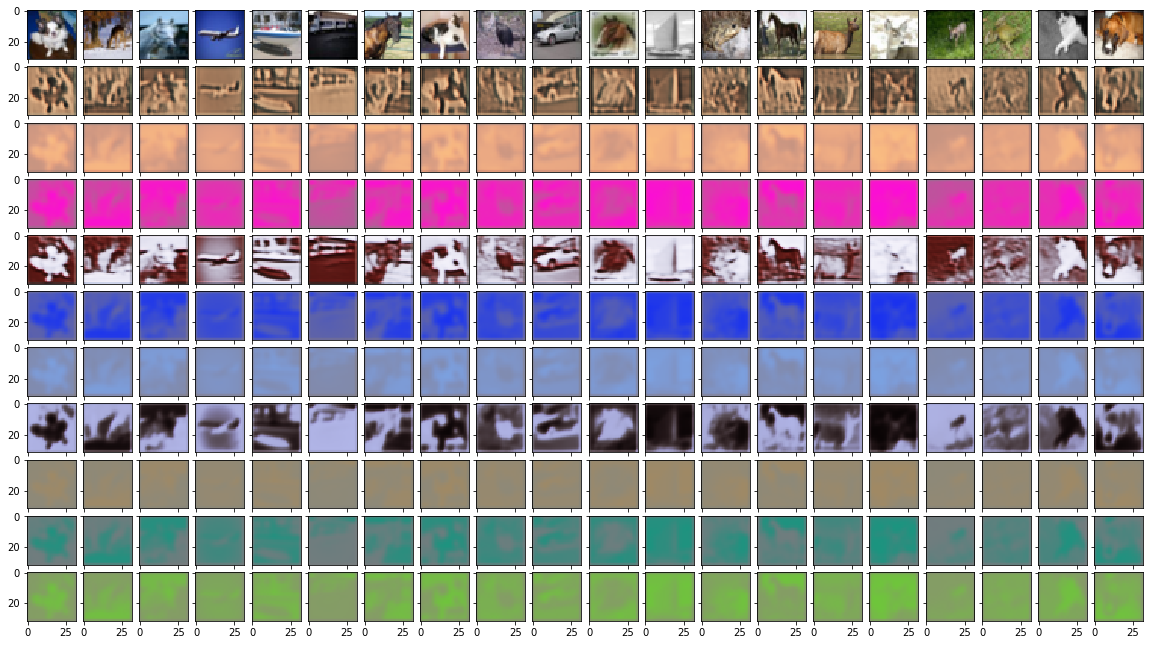

In [17]:
plot_output_grid(output)

In [35]:
data = next(iter(original_mnist_dataset(args.batch_size, args)))[0].numpy()

In [36]:
data.shape

(64, 1, 28, 28)